# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
            * Transfer Learning(Inception V3)
* 성능 가이드
    * Accuracy : 0.34~0.74

## 1.환경설정

* **세부 요구사항**
    - 경로 설정 : Google Colaboratory의 가상 컴퓨터 안에 데이터셋을 다운로드 받고 압축을 해제하세요.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.

In [82]:
!pip install keras --upgrade

In [83]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [84]:
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

#### 1) 데이터 다운로드

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import zipfile     # ZIP 파일을 읽고 쓰는 데 필요한 함수와 클래스 제공

In [87]:
path = '/content/drive/MyDrive/Datasets/'

In [88]:
# 변수 path에 저장된 경로와 file1에 저장된 파일 이름을 결합하여 전체 파일 경로 생성
file1 = 'Car_Images.zip'
path + file1

'/content/drive/MyDrive/Datasets/Car_Images.zip'

In [89]:
# dataset_path = './'  # 현재 디렉토리에 데이터셋이 있다고 가정
# file_path = dataset_path + 'Car_Images.zip'

In [90]:
# 2) 데이터 압축 해제

data = zipfile.ZipFile(path+file1)

try :
    print('압축을 해제합니다.')
    data.extractall(path)
    print('압축 해제가 완료되었습니다.')
except :
    pass
    print('압축이 이미 해제되었거나 이미 폴더가 존재합니다.')

압축을 해제합니다.
압축 해제가 완료되었습니다.


#### 2) 데이터 조회

In [91]:
# 폴더별 이미지 데이터 갯수 확인
# glob 모듈은 지정된 경로에 있는 파일들의 리스트를 반환
print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'abnormal/*'))}장 입니다.")

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.


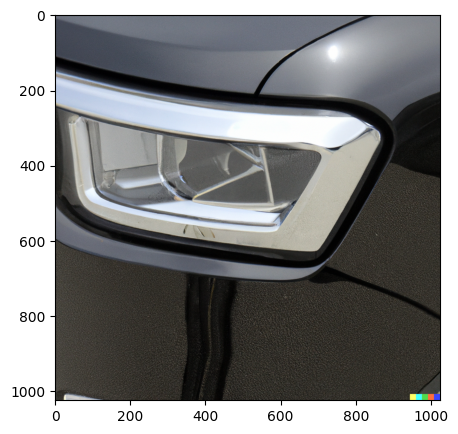

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [92]:
# 정상 차량 랜덤 이미지 확인 및 형태 확인
import random

rand_n = random.randint( 0, len(glob.glob(path+'normal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'normal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

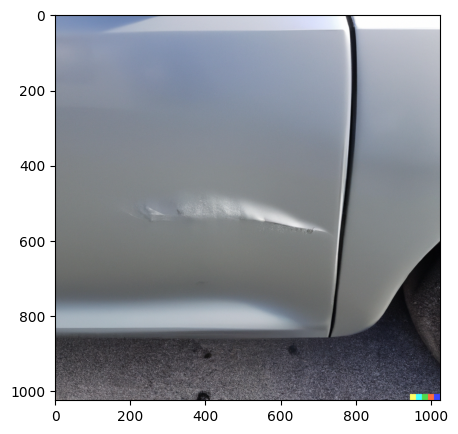

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [93]:
# 파손 차량 랜덤 이미지 확인 및 형태 확인
rand_n = random.randint( 0, len(glob.glob(path+'abnormal/*'))-1 )

plt.figure(figsize=(5,5))
img = plt.imread(glob.glob(path+'abnormal/*')[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 만들기
    * X : 이미지를 array로 변환합니다.
    * Y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.

### (1) Y : 클래스 만들기
- **세부요구사항**
    - 전체 데이터에 대한 Y를 생성합니다.
    - normal, abnormal 데이터의 수를 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [94]:
# 데이터 갯수 확인
print(f"정상 차량 이미지 데이터는 {len(glob.glob(path+'normal/*'))}장 입니다.")
print(f"파손 차량 이미지 데이터는 {len(glob.glob(path+'abnormal/*'))}장 입니다.")

y_normal = [0] * len(glob.glob(path+'normal/*'))
y_abnormal = [1] * len(glob.glob(path+'abnormal/*'))

print(len(y_normal), len(y_abnormal))

Y = y_normal + y_abnormal

정상 차량 이미지 데이터는 302장 입니다.
파손 차량 이미지 데이터는 303장 입니다.
302 303


### (2) X : 데이터 리스트 통합
- **세부요구사항**
    - 전체 이미지 데이터를 하나의 리스트로 통합합니다.

In [95]:
X = []  # 이미지 데이터를 저장할 빈 리스트

normal_data_1 =glob.glob(path+'normal/*')[:]
abnormal_data_2 = glob.glob(path+'abnormal/*')[:]

X.extend(normal_data_1)
X.extend(abnormal_data_2)

print(len(X))

605


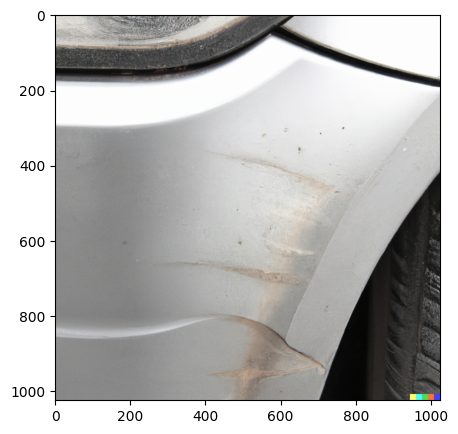

이미지 데이터의 형태는 다음과 같습니다 : (1024, 1024, 3)


In [96]:
# 통합한 뒤 이미지 랜덤으로 잘 나오나 확인
rand_n = random.randint( 0, len(X)-1 )

plt.figure(figsize=(5,5))
img = plt.imread(X[rand_n])
plt.imshow(img)
plt.show()

print(f'이미지 데이터의 형태는 다음과 같습니다 : {img.shape}')

### (3) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [97]:
from sklearn.model_selection import train_test_split

# 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%
# 'Y를 기준으로 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, stratify=Y)

# 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%
# y_train 기준으로 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

# 클래스 레이블을 배열로 변환
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# 각 세트의 길이 확인
print("Train set size:", len(X_train))
print("Validation set size:", len(X_valid))
print("Test set size:", len(X_test))


Train set size: 489
Validation set size: 55
Test set size: 61


### (4) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다.
    * 이미지 파일을 불러와 Training data, Validation data, Test data 각각 array 형태로 변환해 봅시다.

In [98]:
from keras.preprocessing.image import load_img, img_to_array

# 이미지 데이터를 로드, 크기 조정 및 배열로 변환하는 함수
def load_and_preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=(299, 299))
        img_array = img_to_array(img)
        img_array /= 255.0  # 이미지 데이터를 0에서 1 사이의 값으로 스케일 조정
        images.append(img_array)
    return np.array(images)

X = load_and_preprocess_images(X)

len(X)

605

## 3.모델링 I
* **세부요구사항**
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

### (1) 모델 1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

In [99]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

#### 1) 구조 설계

In [100]:
# clear_session()

# 모델 설계
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299,299, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


#### 2) 학습

In [101]:
# 모델 학습
X_train = load_and_preprocess_images(X_train)
X_valid = load_and_preprocess_images(X_valid)
X_test = load_and_preprocess_images(X_test)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.4994 - loss: 2.0476 - val_accuracy: 0.8000 - val_loss: 0.5283
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7771 - loss: 0.5468 - val_accuracy: 0.8182 - val_loss: 0.4923
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.8642 - loss: 0.3457 - val_accuracy: 0.7636 - val_loss: 0.4053
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9372 - loss: 0.1998 - val_accuracy: 0.8000 - val_loss: 0.5230
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9717 - loss: 0.1017 - val_accuracy: 0.7636 - val_loss: 0.6638
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9914 - loss: 0.0617 - val_accuracy: 0.7273 - val_loss: 0.8473
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9970 - loss: 0.0212 - val_accuracy: 0.7273 - val_loss: 1.0679
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.7091 - 

#### 3) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

In [102]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

# 예측 및 평가 메트릭 계산
# 이진 분류에서 사용하는 기본 임계값 0.5
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8386 - loss: 0.4113
Test loss: 0.4035
Test accuracy: 0.8361
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
[[26  4]
 [ 6 25]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        30
           1       0.86      0.81      0.83        31

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



## (2) 모델 2

In [103]:
### 두 번째 모델

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.5297 - loss: 1.3548 - val_accuracy: 0.7091 - val_loss: 0.6375
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.6562 - loss: 0.6315 - val_accuracy: 0.7273 - val_loss: 0.5373
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7796 - loss: 0.5289 - val_accuracy: 0.8182 - val_loss: 0.4170
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8549 - loss: 0.3795 - val_accuracy: 0.8000 - val_loss: 0.4073
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9332 - loss: 0.2869 - val_accuracy: 0.7818 - val_loss: 0.4384
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9193 - loss: 0.2059 - val_accuracy: 0.7636 - val_loss: 0.5219
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9826 - loss: 0.1075 - val_accuracy: 0.7636 - val_loss: 0.6118
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9885 - loss: 0.0548 - val_accuracy: 0.8000 - 

In [104]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8282 - loss: 0.5382
Test loss: 0.5000
Test accuracy: 0.8361


## (3) 모델 3

In [105]:
# 세 번째 모델 정의
model = Sequential()

# 첫 번째 레이어에 Input(shape)를 사용하여 입력 크기 명시
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 819ms/step - accuracy: 0.4974 - loss: 0.6957 - val_accuracy: 0.5091 - val_loss: 0.6863
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - accuracy: 0.5473 - loss: 0.6638 - val_accuracy: 0.7818 - val_loss: 0.5576
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 482ms/step - accuracy: 0.7293 - loss: 0.6203 - val_accuracy: 0.8182 - val_loss: 0.5759
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 514ms/step - accuracy: 0.8004 - loss: 0.5376 - val_accuracy: 0.8364 - val_loss: 0.5160
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 517ms/step - accuracy: 0.7604 - loss: 0.5291 - val_accuracy: 0.7818 - val_loss: 0.4557
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.8103 - loss: 0.4438 - val_accuracy: 0.8182 - val_loss: 0.4159
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 488ms/step - accuracy: 0.8492 - loss: 0.3639 - val_accuracy: 0.7636 - val_loss: 0.4642
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - accuracy: 0.8776 - loss: 0.3624 - val_accuracy: 0

In [106]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - accuracy: 0.8600 - loss: 0.4328
Test loss: 0.4306
Test accuracy: 0.8525


## 4.모델링 II
* **세부요구사항**
    - image_dataset_from_directory를 이용하여 training set, validation set을 만들어봅시다.
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Image Preprocessing Layer, Image Augmentation Layer를 통해 이미지를 변형시켜 봅시다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.

### (1) image_dataset_from_directory

### 1) 데이터셋 분리를 위한 폴더 생성

In [107]:
path

'/content/drive/MyDrive/Datasets/'

In [108]:
import tensorflow as tf

# 이미지 데이터를 불러올 경로 설정
train_path = path + 'Car_Images_train'
val_path = path + 'Car_Images_val'
test_path = path + 'Car_Images_test'

In [109]:
# 학습 데이터셋 생성
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    #label_mode='binary',  # 클래스가 두 개인 경우 binary로 설정
    class_names = ['normal','abnormal'],          # 순서 잘 체크
    batch_size=32,
    image_size=(299, 299),  # 이미지 크기 조정
    seed=2024,  # 시드 설정
    subset="training"  # subset 설정
)

# 검증 데이터셋 생성
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    #label_mode='binary',
     class_names=['normal', 'abnormal'],  # 클래스 이름 지정
    batch_size=32,
    image_size=(299, 299),
    seed=2024,
    shuffle=False,  # 검증 데이터셋에서는 셔플하지 않음
    subset="validation"  # subset 설정
)

# 테스트 데이터셋 생성
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    #label_mode='binary',
     class_names=['normal', 'abnormal'],  # 클래스 이름 지정
    batch_size=32,
    image_size=(299, 299),
    seed=2024,
    shuffle=False,  # 테스트 데이터셋에서는 셔플하지 않음
)


Found 543 files belonging to 2 classes.
Using 435 files for training.
Found 543 files belonging to 2 classes.
Using 108 files for validation.
Found 30 files belonging to 2 classes.


In [110]:
# 클래스 이름 확인
class_names = train_dataset.class_names
print(class_names)

['normal', 'abnormal']


## 1) ImageDataGenerator 생성

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

In [112]:
# ImageDataGenerator를 초기화합니다.
train_gen = ImageDataGenerator(
    rotation_range=90,  # 이미지 회전 각도 범위
    width_shift_range=0.2,  # 이미지 가로 이동 범위
    height_shift_range=0.2,  # 이미지 세로 이동 범위
    shear_range=0.2,  # 전단변환 범위
    zoom_range=0.2,  # 이미지 확대/축소 범위
    horizontal_flip=True,  # 수평 뒤집기
    fill_mode='nearest',  # 이미지를 증강할 때 사용할 픽셀 채우기 방법
    rescale=1./255,
)

valid_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)


## 2) 데이터 경로에서 이미지 불러 올 준비하기

## 3) 구조 설계

In [113]:
# 모델 정의
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## 학습

In [114]:
# 모델 학습
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 830ms/step - accuracy: 0.4843 - loss: 6.5075 - val_accuracy: 0.9352 - val_loss: 0.3270
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.7053 - loss: 0.5544 - val_accuracy: 0.9352 - val_loss: 0.2122
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - accuracy: 0.7373 - loss: 0.5701 - val_accuracy: 0.8333 - val_loss: 0.4861
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 570ms/step - accuracy: 0.8315 - loss: 0.4420 - val_accuracy: 0.8796 - val_loss: 0.3527
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 550ms/step - accuracy: 0.8292 - loss: 0.3932 - val_accuracy: 0.6481 - val_loss: 0.8809
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 547ms/step - accuracy: 0.8226 - loss: 0.4547 - val_accuracy: 0.9167 - val_loss: 0.2582
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 527ms/step - accuracy: 0.8916 - loss: 0.3014 - val_accuracy: 0.6759 - val_loss: 0.8488


### 5) 성능 평가

In [115]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측 및 평가 메트릭 계산
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
[[17 13]
 [ 4 27]]
              precision    recall  f1-score   support

           0       0.81      0.57      0.67        30
           1       0.68      0.87      0.76        31

    accuracy                           0.72        61
   macro avg       0.74      0.72      0.71        61
weighted avg       0.74      0.72      0.71        61



In [116]:
# 학습이 완료된 후에 테스트 데이터셋을 사용하여 모델을 평가합니다.
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step - accuracy: 0.8333 - loss: 0.4259
Test Loss: 0.4258987605571747
Test Accuracy: 0.8333333134651184


### (2) Transfer Learning

#### 1) Inception V3 모델을 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 False로 설정하여 불러온 모델의 모든 레이어들을 Frozen 시켜 가중치를 고정합니다.
- 각 이미지에 preprocess_input 함수를 적용

### 전처리

In [117]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

# 학습 데이터셋에 대한 전처리
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))

# 검증 데이터셋에 대한 전처리
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

# 테스트 데이터셋에 대한 전처리
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

In [146]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


# 사전 훈련된 InceptionV3 모델을 로드합니다.
base_model = InceptionV3(
    weights='imagenet',         # ImageNet 데이터셋으로 사전 훈련된 가중치를 로드합니다.
    include_top=False,          # 모델의 마지막 Fully Connected 레이어를 포함하지 않습니다.
    input_shape=(299, 299, 3)
)

new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(1, activation = 'sigmoid')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

# 기본 모델의 모든 레이어를 동결합니다.
for layer in base_model.layers:
    layer.trainable = False

In [139]:
print(f'모델의 레이어 수 : {len(model.layers)}')

모델의 레이어 수 : 313


#### 2) Inception V3 모델과 연결하여 구조 설계
* Inception V3을 불러온 후, 다른 레이어와 연결하기
* Image Preprocessing Layer, Image Augmentation Layer를 사용해보세요.

In [147]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'],
             optimizer=Adam(learning_rate=0.0001))

In [148]:
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

#### 3) 학습

In [149]:
# 모델을 학습시킵니다.
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.4372 - loss: 0.7393 - val_accuracy: 0.6944 - val_loss: 0.6245
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.4837 - loss: 0.6980 - val_accuracy: 0.7407 - val_loss: 0.6126
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.5640 - loss: 0.6681 - val_accuracy: 0.7593 - val_loss: 0.6154
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.6165 - loss: 0.6397 - val_accuracy: 0.8519 - val_loss: 0.5420
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.7202 - loss: 0.5870 - val_accuracy: 0.8704 - val_loss: 0.5153
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8016 - loss: 0.5605 - val_accuracy: 0.8704 - val_loss: 0.5153
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - accuracy: 0.8253 - loss: 0.5397 - val_accuracy: 0.8796 - val_loss: 0.5060
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8468 - loss: 0.5152 - val_accuracy: 0.88

#### 4) 성능 평가

In [150]:
# 학습이 완료된 후에 테스트 데이터셋을 사용하여 모델을 평가합니다.
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: 0.1632
Test Loss: 0.16319595277309418
Test Accuracy: 1.0
